# Flint — LSTM Forecaster (Colab/GPU Notebook)

This notebook is a Colab-friendly version of `forecasting_engine.py` with:
- GPU training when available (`cuda`)
- More verbose hyperparameter tuning
- Plots for **train/val curves**, tuning results, and **test diagnostics**

## How to run on Colab
1. Runtime → Change runtime type → **GPU**
2. Ensure the CSVs exist in a data directory containing:
   - `df_h.csv`, `df_m.csv`, `df_u.csv`, `df_z.csv`
3. Set `DATA_DIR` in the config cell below (you can upload files, mount Drive, or `git clone` your repo).

In [1]:
# Install dependencies (Colab usually already has torch, but this ensures sklearn/tqdm, etc.)
import sys, subprocess
def pip_install(*pkgs):
    cmd = [sys.executable, '-m', 'pip', 'install', '-q', *pkgs]
    print(' '.join(cmd))
    subprocess.check_call(cmd)

pip_install('numpy', 'pandas', 'matplotlib', 'scikit-learn', 'tqdm')

# Optional: uncomment to install torch explicitly (Colab already includes CUDA builds)
# pip_install('torch')

/usr/bin/python3 -m pip install -q numpy pandas matplotlib scikit-learn tqdm


In [2]:
import json, math, random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import confusion_matrix

FEATURE_COLS = ['open', 'high', 'low', 'close', 'volume']
CLOSE_IDX = FEATURE_COLS.index('close')

def seed_all(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
if device.type == 'cuda':
    print('gpu:', torch.cuda.get_device_name(0))

device: cuda
gpu: Tesla T4


## Data location

Set `DATA_DIR` to a folder containing `df_h.csv`, `df_m.csv`, `df_u.csv`, `df_z.csv`.

Common Colab options:
- Upload files into `/content/data`
- Mount Drive and point to `/content/drive/MyDrive/.../data`
- `git clone` your repo and point to `.../services/backend/model/data`

In [ ]:
# === CONFIG ===
seed_all(42)

# Point this to your data directory on Colab
DATA_DIR = Path('/content/data')  # <-- change this

# Feature transforms
LOG_VOLUME = True  # helps stabilize heavy-tailed volume

# Model + target setup
MODEL_NAME = 'attn_lstm'  # try: 'direct_lstm', 'attn_lstm', 'cnn_lstm'
TARGET_MODE = 'delta_last'  # predict deltas from last input step (usually easier)

# Training / tuning knobs
BATCH_SIZE = 32
HORIZON = 60
DAYS_PER_SAMPLE = 7
STRIDE_DAYS = 1
MIN_DAY_LEN_RATIO = 0.9

TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.8, 0.1, 0.1

# Train longer + validate longer
FINAL_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 8

# Hyperparameter tuning (still lightweight)
TUNE_TRIALS = 15
TUNE_EPOCHS = 5
MAX_TRAIN_BATCHES_PER_EPOCH = 250
MAX_VAL_BATCHES = 80

ARTIFACTS_DIR = Path('/content/artifacts')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
print('ARTIFACTS_DIR:', ARTIFACTS_DIR)

required = ['df_h.csv','df_m.csv','df_u.csv','df_z.csv']
missing = [f for f in required if not (DATA_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        f"DATA_DIR={DATA_DIR} is missing: {missing}\n"
        "Upload the files or change DATA_DIR."
    )

ARTIFACTS_DIR: /content/artifacts


In [ ]:
def load_contract_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    expected = {'ts_event','open','high','low','close','volume','contract_month'}
    missing = expected - set(df.columns)
    if missing:
        raise ValueError(f"{path.name} missing columns: {sorted(missing)}")

    df = df.copy()
    df['ts_event'] = pd.to_datetime(df['ts_event'], errors='coerce')
    df = df.dropna(subset=['ts_event'])
    df = df.sort_values('ts_event').reset_index(drop=True)

    for col in FEATURE_COLS:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=FEATURE_COLS)

    if LOG_VOLUME:
        # volume can be heavy-tailed; log1p makes it easier to learn
        df['volume'] = np.log1p(np.maximum(df['volume'].to_numpy(dtype=np.float64), 0.0)).astype(np.float32)

    for col in FEATURE_COLS:
        df[col] = df[col].astype(np.float32)
    df['contract_month'] = df['contract_month'].astype(str)
    return df

def compute_median_trading_minutes_per_day(df: pd.DataFrame) -> int:
    day_counts = df.groupby(df['ts_event'].dt.date).size().astype(int)
    if day_counts.empty:
        raise ValueError('No daily rows found')
    median_count = int(day_counts.median())
    if median_count <= 0:
        raise ValueError('Median daily count is <= 0')
    return median_count

def build_day_segments(
    df: pd.DataFrame,
    *,
    day_len: int,
    min_day_len_ratio: float = 0.9,
) -> Tuple[np.ndarray, List[Tuple[int,int]], List[pd.Timestamp]]:
    if day_len <= 60:
        raise ValueError('day_len must be > 60 to hold a 1-hour target')

    df = df.sort_values('ts_event').reset_index(drop=True)
    data = df[FEATURE_COLS].to_numpy(dtype=np.float32, copy=True)

    groups = df.groupby(df['ts_event'].dt.date, sort=True)
    day_segments: List[Tuple[int,int]] = []
    day_starts: List[pd.Timestamp] = []
    min_len = int(day_len * min_day_len_ratio)

    for _, g in groups:
        if len(g) < min_len:
            continue
        day_start_idx = int(g.index.min())
        day_end_idx = int(g.index.max()) + 1
        if (day_end_idx - day_start_idx) < day_len:
            continue
        seg_end = day_end_idx
        seg_start = seg_end - day_len
        day_segments.append((seg_start, seg_end))
        day_starts.append(pd.Timestamp(g['ts_event'].iloc[0]))

    if not day_segments:
        raise ValueError('No valid day segments were created; check day_len/min_day_len_ratio')

    return data, day_segments, day_starts

class WeekToHourDataset(torch.utils.data.Dataset):
    """7 trading days -> predict last hour (60 minutes)."""
    def __init__(
        self,
        *,
        contract_name: str,
        data: np.ndarray,
        day_segments: List[Tuple[int,int]],
        week_starts: List[int],
        day_len: int,
        days_per_sample: int = 7,
        horizon: int = 60,
        mean: Optional[np.ndarray] = None,
        std: Optional[np.ndarray] = None,
    ):
        self.contract_name = contract_name
        self.data = data
        self.day_segments = day_segments
        self.week_starts = week_starts
        self.day_len = day_len
        self.days_per_sample = days_per_sample
        self.horizon = horizon
        self.mean = mean
        self.std = std

        self.total_len = self.days_per_sample * day_len
        if self.total_len <= horizon:
            raise ValueError('Total sample length must be > horizon')
        self.input_len = self.total_len - horizon

    def __len__(self) -> int:
        return len(self.week_starts)

    def set_scaler(self, mean: np.ndarray, std: np.ndarray) -> None:
        self.mean = mean.astype(np.float32)
        self.std = std.astype(np.float32)

    def _get_week_array(self, start_day_idx: int) -> np.ndarray:
        segs = self.day_segments[start_day_idx : start_day_idx + self.days_per_sample]
        parts = [self.data[s:e] for (s, e) in segs]
        return np.concatenate(parts, axis=0)

    def __getitem__(self, idx: int):
        start_day = self.week_starts[idx]
        seq = self._get_week_array(start_day)
        x = seq[: self.input_len]
        y = seq[self.input_len :]
        if self.mean is not None and self.std is not None:
            x = (x - self.mean) / self.std
            y = (y - self.mean) / self.std
        return (
            torch.from_numpy(x).to(torch.float32),
            torch.from_numpy(y).to(torch.float32),
        )

def compute_global_scaler_from_train(
    train_datasets: Sequence[WeekToHourDataset],
    *,
    eps: float = 1e-6,
) -> Tuple[np.ndarray, np.ndarray]:
    sum_vec = np.zeros((len(FEATURE_COLS),), dtype=np.float64)
    sumsq_vec = np.zeros((len(FEATURE_COLS),), dtype=np.float64)
    count = 0
    for ds in train_datasets:
        for start_day in ds.week_starts:
            seq = ds._get_week_array(start_day)
            x = seq[: ds.input_len]
            sum_vec += x.sum(axis=0)
            sumsq_vec += (x * x).sum(axis=0)
            count += x.shape[0]
    if count == 0:
        raise ValueError('No training rows to compute scaler')
    mean = (sum_vec / count).astype(np.float32)
    var = (sumsq_vec / count) - (mean.astype(np.float64) ** 2)
    std = np.sqrt(np.maximum(var, 0.0)).astype(np.float32)
    std = np.where(std < eps, np.float32(1.0), std)
    return mean, std

def build_datasets_for_contract(
    contract_name: str,
    df: pd.DataFrame,
    *,
    train_frac: float,
    val_frac: float,
    test_frac: float,
    day_len_override: Optional[int] = None,
    days_per_sample: int = 7,
    stride_days: int = 1,
    horizon: int = 60,
    min_day_len_ratio: float = 0.9,
) -> Dict[str, WeekToHourDataset]:
    day_len = day_len_override or compute_median_trading_minutes_per_day(df)
    data, day_segments, _day_starts = build_day_segments(
        df, day_len=day_len, min_day_len_ratio=min_day_len_ratio
    )
    if days_per_sample < 2:
        raise ValueError('days_per_sample must be >= 2')
    if stride_days < 1:
        raise ValueError('stride_days must be >= 1')
    if len(day_segments) < days_per_sample:
        raise ValueError(f'Not enough days to form a sample for {contract_name}')

    n_days = len(day_segments)
    train_day_end = int(n_days * train_frac)
    val_day_end = int(n_days * (train_frac + val_frac))
    train_day_end = max(days_per_sample, train_day_end)
    val_day_end = max(train_day_end + days_per_sample, val_day_end)
    val_day_end = min(n_days, val_day_end)

    def starts_in_range(day_start: int, day_end: int) -> List[int]:
        last_start = day_end - days_per_sample
        if last_start < day_start:
            return []
        return list(range(day_start, last_start + 1, stride_days))

    train_starts = starts_in_range(0, train_day_end)
    val_starts = starts_in_range(train_day_end, val_day_end)
    test_starts = starts_in_range(val_day_end, n_days)

    if len(train_starts) < 5 or len(val_starts) < 1 or len(test_starts) < 1:
        raise ValueError(
            f'Not enough samples after split for {contract_name}: '
            f'train={len(train_starts)} val={len(val_starts)} test={len(test_starts)} '
            f'(days={n_days}, days_per_sample={days_per_sample}, stride={stride_days})'
        )

    return {
        'train': WeekToHourDataset(
            contract_name=contract_name, data=data, day_segments=day_segments,
            week_starts=train_starts, day_len=day_len, days_per_sample=days_per_sample, horizon=horizon,
        ),
        'val': WeekToHourDataset(
            contract_name=contract_name, data=data, day_segments=day_segments,
            week_starts=val_starts, day_len=day_len, days_per_sample=days_per_sample, horizon=horizon,
        ),
        'test': WeekToHourDataset(
            contract_name=contract_name, data=data, day_segments=day_segments,
            week_starts=test_starts, day_len=day_len, days_per_sample=days_per_sample, horizon=horizon,
        ),
    }

In [ ]:
# --- Model zoo (modular) ---

def build_seq2seq_lstm_forecaster(
    *,
    input_size: int = 5,
    hidden_size: int = 192,
    num_layers: int = 2,
    dropout: float = 0.1,
) -> nn.Module:
    """Seq2Seq LSTM: encoder over input, decoder over horizon (teacher forcing supported)."""
    class Seq2SeqLSTMForecaster(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.LSTM(
                input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0.0,
            )
            self.decoder = nn.LSTM(
                input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0.0,
            )
            self.proj = nn.Linear(hidden_size, input_size)

        def forward(self, x, y=None, *, horizon: int = 60, teacher_forcing: bool = True):
            # x: (B, Tin, F) | y: (B, H, F) optional
            _enc_out, (h, c) = self.encoder(x)
            if teacher_forcing and y is not None:
                last_x = x[:, -1:, :]
                dec_in = torch.cat([last_x, y[:, :-1, :]], dim=1)
                dec_out, _ = self.decoder(dec_in, (h, c))
                return self.proj(dec_out)

            # Autoregressive decode (used rarely here; teacher forcing is fine for training/eval)
            preds = []
            inp = x[:, -1:, :]
            state = (h, c)
            for _ in range(horizon):
                dec_out, state = self.decoder(inp, state)
                step = self.proj(dec_out)
                preds.append(step)
                inp = step
            return torch.cat(preds, dim=1)

    return Seq2SeqLSTMForecaster()

def build_direct_lstm_forecaster(
    *,
    input_size: int = 5,
    hidden_size: int = 128,
    num_layers: int = 2,
    dropout: float = 0.1,
    horizon: int = 60,
    output_size: int = 5,
) -> nn.Module:
    class DirectLSTMForecaster(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(
                input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0.0,
            )
            self.head = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, horizon * output_size),
            )
            self.horizon = horizon
            self.output_size = output_size

        def forward(self, x, y=None, *, horizon: Optional[int] = None, teacher_forcing: bool = True):
            _out, (h, _c) = self.lstm(x)
            last = h[-1]
            hzn = int(horizon) if horizon is not None else self.horizon
            return self.head(last).view(x.shape[0], hzn, self.output_size)

    return DirectLSTMForecaster()

def build_attn_lstm_forecaster(
    *,
    input_size: int = 5,
    hidden_size: int = 192,
    num_layers: int = 2,
    dropout: float = 0.1,
    horizon: int = 60,
    output_size: int = 5,
) -> nn.Module:
    """LSTM over the full sequence + attention pooling over time."""
    class AttnLSTMForecaster(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(
                input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0.0,
            )
            self.attn = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1),
            )
            self.head = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, horizon * output_size),
            )
            self.horizon = horizon
            self.output_size = output_size

        def forward(self, x, y=None, *, horizon: Optional[int] = None, teacher_forcing: bool = True):
            out, _state = self.lstm(x)  # (B, T, H)
            scores = self.attn(out).squeeze(-1)  # (B, T)
            weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # (B, T, 1)
            ctx = (weights * out).sum(dim=1)  # (B, H)
            hzn = int(horizon) if horizon is not None else self.horizon
            return self.head(ctx).view(x.shape[0], hzn, self.output_size)

    return AttnLSTMForecaster()

def build_cnn_lstm_forecaster(
    *,
    input_size: int = 5,
    conv_channels: int = 64,
    hidden_size: int = 160,
    num_layers: int = 2,
    dropout: float = 0.1,
    horizon: int = 60,
    output_size: int = 5,
) -> nn.Module:
    """Strided CNN to compress long sequences, then an LSTM encoder."""
    class CNNLSTMForecaster(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv = nn.Sequential(
                nn.Conv1d(input_size, conv_channels, kernel_size=7, stride=2, padding=3),
                nn.ReLU(),
                nn.Conv1d(conv_channels, conv_channels, kernel_size=5, stride=2, padding=2),
                nn.ReLU(),
                nn.Conv1d(conv_channels, conv_channels, kernel_size=5, stride=2, padding=2),
                nn.ReLU(),
            )
            self.lstm = nn.LSTM(
                input_size=conv_channels, hidden_size=hidden_size, num_layers=num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0.0,
            )
            self.head = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_size, horizon * output_size),
            )
            self.horizon = horizon
            self.output_size = output_size

        def forward(self, x, y=None, *, horizon: Optional[int] = None, teacher_forcing: bool = True):
            z = self.conv(x.transpose(1, 2)).transpose(1, 2)  # (B, T', C)
            _out, (h, _c) = self.lstm(z)
            last = h[-1]
            hzn = int(horizon) if horizon is not None else self.horizon
            return self.head(last).view(x.shape[0], hzn, self.output_size)

    return CNNLSTMForecaster()

def build_model(*, name: str, horizon: int, output_size: int) -> nn.Module:
    name = name.strip().lower()
    if name == 'direct_lstm':
        return build_direct_lstm_forecaster(input_size=len(FEATURE_COLS), horizon=horizon, output_size=output_size)
    if name == 'attn_lstm':
        return build_attn_lstm_forecaster(input_size=len(FEATURE_COLS), horizon=horizon, output_size=output_size)
    if name == 'cnn_lstm':
        return build_cnn_lstm_forecaster(input_size=len(FEATURE_COLS), horizon=horizon, output_size=output_size)
    if name == 'seq2seq_lstm':
        # horizon not baked into this model; passed at forward-time
        return build_seq2seq_lstm_forecaster(input_size=len(FEATURE_COLS))
    raise ValueError(f"Unknown MODEL_NAME={name!r}. Try: 'direct_lstm', 'attn_lstm', 'cnn_lstm', 'seq2seq_lstm'")

In [ ]:
def _make_delta_targets(xb: torch.Tensor, yb_abs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Return (yb_delta, last_x) in normalized space."""
    last_x = xb[:, -1:, :]  # (B, 1, F)
    yb_delta = yb_abs - last_x  # (B, H, F)
    return yb_delta, last_x

def _delta_to_abs(last_x: torch.Tensor, y_delta: torch.Tensor) -> torch.Tensor:
    return y_delta + last_x

def evaluate_model(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """Returns ABSOLUTE-space MSE in normalized units (lower is better)."""
    model.eval()
    loss_fn = nn.MSELoss()
    losses: List[float] = []
    with torch.no_grad():
        for xb, yb_abs in loader:
            xb = xb.to(device)
            yb_abs = yb_abs.to(device)

            if TARGET_MODE == 'delta_last':
                yb_delta, last_x = _make_delta_targets(xb, yb_abs)
                pred_delta = model(xb, yb_delta, horizon=yb_delta.shape[1], teacher_forcing=True)
                pred_abs = _delta_to_abs(last_x, pred_delta)
            else:
                pred_abs = model(xb, yb_abs, horizon=yb_abs.shape[1], teacher_forcing=True)

            losses.append(loss_fn(pred_abs, yb_abs).item())
    return float(np.mean(losses)) if losses else float('nan')

def evaluate_model_limited(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    *,
    max_batches: Optional[int] = None,
) -> float:
    model.eval()
    loss_fn = nn.MSELoss()
    losses: List[float] = []
    with torch.no_grad():
        for i, (xb, yb_abs) in enumerate(loader):
            if max_batches is not None and i >= max_batches:
                break
            xb = xb.to(device)
            yb_abs = yb_abs.to(device)

            if TARGET_MODE == 'delta_last':
                yb_delta, last_x = _make_delta_targets(xb, yb_abs)
                pred_delta = model(xb, yb_delta, horizon=yb_delta.shape[1], teacher_forcing=True)
                pred_abs = _delta_to_abs(last_x, pred_delta)
            else:
                pred_abs = model(xb, yb_abs, horizon=yb_abs.shape[1], teacher_forcing=True)

            losses.append(loss_fn(pred_abs, yb_abs).item())
    return float(np.mean(losses)) if losses else float('nan')

def predict_one_unscaled(
    model: nn.Module, dataset: WeekToHourDataset, idx: int, device: torch.device
) -> Tuple[np.ndarray, np.ndarray]:
    """Returns (pred_abs, actual_abs) in ORIGINAL units, arrays shaped (horizon, F)."""
    model.eval()
    xb, yb_abs = dataset[idx]
    with torch.no_grad():
        xb_b = xb.unsqueeze(0).to(device)
        yb_b = yb_abs.unsqueeze(0).to(device)
        if TARGET_MODE == 'delta_last':
            yb_delta, last_x = _make_delta_targets(xb_b, yb_b)
            pred_delta = model(xb_b, yb_delta, horizon=yb_delta.shape[1], teacher_forcing=True)
            pred_abs = _delta_to_abs(last_x, pred_delta)
        else:
            pred_abs = model(xb_b, yb_b, horizon=yb_b.shape[1], teacher_forcing=True)
        pred_abs = pred_abs.squeeze(0).cpu().numpy().astype(np.float32)
    actual = yb_abs.cpu().numpy().astype(np.float32)

    if dataset.mean is not None and dataset.std is not None:
        pred_abs = pred_abs * dataset.std + dataset.mean
        actual = actual * dataset.std + dataset.mean
    return pred_abs, actual

def plot_forecast_vs_actual(
    *,
    model: nn.Module,
    dataset: WeekToHourDataset,
    idx: int,
    device: torch.device,
    save_path: Optional[Path] = None,
    show: bool = True,
) -> None:
    pred, actual = predict_one_unscaled(model, dataset, idx, device)
    t = np.arange(pred.shape[0])
    fig, axes = plt.subplots(nrows=len(FEATURE_COLS), ncols=1, figsize=(10, 10), sharex=True)
    if len(FEATURE_COLS) == 1:
        axes = [axes]
    for i, col in enumerate(FEATURE_COLS):
        ax = axes[i]
        ax.plot(t, actual[:, i], label='actual', linewidth=2)
        ax.plot(t, pred[:, i], label='forecast', linewidth=2)
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend(loc='best')
    axes[-1].set_xlabel('minute (last hour)')
    fig.suptitle(f"{dataset.contract_name} sample={idx} (last-hour forecast)")
    fig.tight_layout()
    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=160)
        print('plot_saved:', str(save_path))
    if show:
        plt.show()
    plt.close(fig)

In [ ]:
def train_verbose(
    model: nn.Module,
    *,
    train_loader: DataLoader,
    val_loaders: Dict[str, DataLoader],
    epochs: int,
    lr: float,
    device: torch.device,
    max_train_batches_per_epoch: Optional[int] = None,
    patience: int = 8,
    min_delta: float = 1e-5,
) -> Dict[str, object]:
    """Train on delta targets (if enabled) but report/early-stop on ABS val MSE."""
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)

    history = {
        'train_delta_mse': [],
        'val_abs_mse': {k: [] for k in val_loaders.keys()},
        'val_abs_mean': [],
        'lr': [],
        'best_epoch': None,
        'best_val': float('inf'),
        'best_state_dict': None,
    }

    bad_epochs = 0
    for epoch in range(1, epochs + 1):
        model.train()
        train_losses: List[float] = []
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        for i, (xb, yb_abs) in pbar:
            if max_train_batches_per_epoch is not None and i >= max_train_batches_per_epoch:
                break
            xb = xb.to(device)
            yb_abs = yb_abs.to(device)

            if TARGET_MODE == 'delta_last':
                yb_delta, _last_x = _make_delta_targets(xb, yb_abs)
                y_train = yb_delta
            else:
                y_train = yb_abs

            opt.zero_grad(set_to_none=True)
            pred = model(xb, y_train, horizon=y_train.shape[1], teacher_forcing=True)
            loss = loss_fn(pred, y_train)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            train_losses.append(loss.item())
            if i % 25 == 0:
                pbar.set_description(f"epoch {epoch}/{epochs} train_delta_mse={np.mean(train_losses):.6f}")

        train_delta_mse = float(np.mean(train_losses)) if train_losses else float('nan')
        history['train_delta_mse'].append(train_delta_mse)
        history['lr'].append(float(opt.param_groups[0]['lr']))

        # Val ABS MSE (what you actually care about)
        val_report = {name: evaluate_model(model, loader, device) for name, loader in val_loaders.items()}
        for name, v in val_report.items():
            history['val_abs_mse'][name].append(float(v))
        val_mean = float(np.mean(list(val_report.values()))) if val_report else float('inf')
        history['val_abs_mean'].append(val_mean)

        scheduler.step(val_mean)
        val_str = ' '.join([f"{k}={v:.6f}" for k, v in val_report.items()])
        print(f"epoch={epoch:03d}/{epochs} lr={opt.param_groups[0]['lr']:.2e} train_delta_mse={train_delta_mse:.6f} val_abs_mean={val_mean:.6f} {val_str}")

        if val_mean + min_delta < history['best_val']:
            history['best_val'] = val_mean
            history['best_epoch'] = epoch
            history['best_state_dict'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"early_stop: epoch={epoch} best_epoch={history['best_epoch']} best_val_abs_mean={history['best_val']:.6f}")
                break

    # Restore best weights (helps test)
    if history['best_state_dict'] is not None:
        model.load_state_dict(history['best_state_dict'])
    return history

def plot_training_curves(history: Dict[str, object], title: str = 'Training Curves') -> None:
    train = history['train_delta_mse']
    val = history['val_abs_mse']
    epochs = np.arange(1, len(train) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train, label='train_delta_mse', linewidth=2)
    for name, series in val.items():
        plt.plot(epochs, series, label=name.replace('val_', 'val_abs_'), linewidth=2)
    plt.xlabel('epoch')
    plt.ylabel('MSE (normalized)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def mean_metric(report: Dict[str, float]) -> float:
    vals = [v for v in report.values() if not (math.isnan(v) or math.isinf(v))]
    return float(np.mean(vals)) if vals else float('inf')

def tune_hyperparameters_verbose(
    *,
    model_name: str,
    contract_splits: Dict[str, Dict[str, WeekToHourDataset]],
    device: torch.device,
    tune_trials: int,
    tune_epochs: int,
    batch_size: int,
    horizon: int,
    max_train_batches_per_epoch: int,
    max_val_batches: int,
    rng_seed: int = 42,
) -> Dict[str, object]:
    rng = random.Random(rng_seed)

    # Candidate spaces (kept sane for speed)
    hidden_sizes = [128, 192, 256]
    num_layers_list = [1, 2, 3]
    dropouts = [0.0, 0.1, 0.2]
    lrs = [1e-3, 3e-4, 1e-4]

    train_concat = ConcatDataset([contract_splits[c]['train'] for c in contract_splits])
    train_loader = DataLoader(train_concat, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    val_loaders = {
        f"val_{c}": DataLoader(contract_splits[c]['val'], batch_size=batch_size, shuffle=False, num_workers=0)
        for c in contract_splits
    }

    trials = []
    best = {'score': float('inf'), 'params': None, 'report': None, 'trial': None}

    for trial in range(1, tune_trials + 1):
        hidden = rng.choice(hidden_sizes)
        layers = rng.choice(num_layers_list)
        drop = rng.choice(dropouts)
        lr = rng.choice(lrs)

        name = model_name.strip().lower()
        if name == 'direct_lstm':
            model = build_direct_lstm_forecaster(
                input_size=len(FEATURE_COLS), hidden_size=hidden, num_layers=layers, dropout=drop,
                horizon=horizon, output_size=len(FEATURE_COLS)
            ).to(device)
        elif name == 'attn_lstm':
            model = build_attn_lstm_forecaster(
                input_size=len(FEATURE_COLS), hidden_size=hidden, num_layers=layers, dropout=drop,
                horizon=horizon, output_size=len(FEATURE_COLS)
            ).to(device)
        elif name == 'cnn_lstm':
            model = build_cnn_lstm_forecaster(
                input_size=len(FEATURE_COLS), hidden_size=hidden, num_layers=layers, dropout=drop,
                horizon=horizon, output_size=len(FEATURE_COLS)
            ).to(device)
        elif name == 'seq2seq_lstm':
            model = build_seq2seq_lstm_forecaster(
                input_size=len(FEATURE_COLS), hidden_size=hidden, num_layers=layers, dropout=drop
            ).to(device)
        else:
            model = build_model(name=model_name, horizon=horizon, output_size=len(FEATURE_COLS)).to(device)

        hist = train_verbose(
            model,
            train_loader=train_loader,
            val_loaders=val_loaders,
            epochs=tune_epochs,
            lr=lr,
            device=device,
            max_train_batches_per_epoch=max_train_batches_per_epoch,
            patience=max(2, min(5, tune_epochs)),
        )

        final_report = {
            name: evaluate_model_limited(model, loader, device, max_batches=max_val_batches)
            for name, loader in val_loaders.items()
        }
        score = mean_metric(final_report)
        params = {'hidden_size': hidden, 'num_layers': layers, 'dropout': drop, 'lr': lr}
        print(f"tune trial={trial}/{tune_trials} score={score:.6f} params={params} report={final_report}")

        row = {'trial': trial, 'score': score, **params, **final_report}
        trials.append(row)
        if score < best['score']:
            best = {'score': score, 'params': params, 'report': final_report, 'trial': trial}

    df_trials = pd.DataFrame(trials).sort_values('score').reset_index(drop=True)
    print('best_tune:', best)
    return {'best': best, 'trials_df': df_trials}

def plot_tuning_results(trials_df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 4))
    plt.plot(trials_df.sort_values('trial')['trial'], trials_df.sort_values('trial')['score'], marker='o')
    plt.xlabel('trial')
    plt.ylabel('mean val ABS MSE (score)')
    plt.title('Hyperparameter Tuning Score vs Trial')
    plt.grid(True, alpha=0.3)
    plt.show()
    display(trials_df)

In [8]:
# Load all contracts and build dataset splits
files = {
    'H': DATA_DIR / 'df_h.csv',
    'M': DATA_DIR / 'df_m.csv',
    'U': DATA_DIR / 'df_u.csv',
    'Z': DATA_DIR / 'df_z.csv',
}

contract_dfs: Dict[str, pd.DataFrame] = {}
median_day_lens: Dict[str, int] = {}
for contract_name, path in files.items():
    df = load_contract_csv(path)
    contract_dfs[contract_name] = df
    median_day_lens[contract_name] = compute_median_trading_minutes_per_day(df)

global_day_len = int(min(median_day_lens.values()))
if global_day_len <= HORIZON:
    raise ValueError(f'global_day_len ({global_day_len}) must be > horizon ({HORIZON})')
print('median_day_lens:', median_day_lens, 'global_day_len:', global_day_len)

contract_splits: Dict[str, Dict[str, WeekToHourDataset]] = {}
for contract_name, df in contract_dfs.items():
    contract_splits[contract_name] = build_datasets_for_contract(
        contract_name, df,
        train_frac=TRAIN_FRAC, val_frac=VAL_FRAC, test_frac=TEST_FRAC,
        day_len_override=global_day_len,
        days_per_sample=DAYS_PER_SAMPLE, stride_days=STRIDE_DAYS, horizon=HORIZON,
        min_day_len_ratio=MIN_DAY_LEN_RATIO,
    )
    ds_train = contract_splits[contract_name]['train']
    print(
        f"{contract_name}: train={len(contract_splits[contract_name]['train'])} "
        f"val={len(contract_splits[contract_name]['val'])} "
        f"test={len(contract_splits[contract_name]['test'])} "
        f"day_len={ds_train.day_len} input_len={ds_train.input_len}"
    )

# Global scaler computed from all training inputs across all contract months
train_datasets = [contract_splits[c]['train'] for c in contract_splits]
mean, std = compute_global_scaler_from_train(train_datasets)
for c in contract_splits:
    for split_name in ('train','val','test'):
        contract_splits[c][split_name].set_scaler(mean, std)
print('global_scaler:', {k: float(v) for k, v in zip(FEATURE_COLS, mean)})

median_day_lens: {'H': 140, 'M': 180, 'U': 189, 'Z': 120} global_day_len: 120
H: train=1034 val=124 test=125 day_len=120 input_len=780
M: train=1121 val=135 test=135 day_len=120 input_len=780
U: train=1165 val=140 test=141 day_len=120 input_len=780
Z: train=1099 val=132 test=133 day_len=120 input_len=780
global_scaler: {'open': 3255.4794921875, 'high': 3255.8310546875, 'low': 3255.126220703125, 'close': 3255.477783203125, 'volume': 527.9417724609375}


## Optional: benchmark multiple models

By default, this notebook tunes/trains/tests **one** model: the one selected by `MODEL_NAME` in the config.

If you want to compare models automatically, enable the benchmark cell below. It will:
- Tune each model briefly
- Train it (with early stopping)
- Report test MSE per contract + mean test MSE
- Print a leaderboard and optionally pick the best model

In [ ]:
# === BENCHMARK MULTIPLE MODELS (optional) ===
RUN_BENCHMARK = False  # set True to compare models automatically
BENCH_MODELS = ['direct_lstm', 'attn_lstm', 'cnn_lstm', 'seq2seq_lstm']

# Keep benchmark relatively fast; increase if you have time/GPU budget
BENCH_TUNE_TRIALS = 8
BENCH_TUNE_EPOCHS = 3
BENCH_FINAL_EPOCHS = 25
BENCH_MAX_TRAIN_BATCHES_PER_EPOCH = 250
BENCH_MAX_VAL_BATCHES = 80

def _mean_dict(d: Dict[str, float]) -> float:
    vals = [float(v) for v in d.values()]
    return float(np.mean(vals)) if vals else float('inf')

def run_one_model_end_to_end(model_name: str) -> Dict[str, object]:
    print('\n' + '='*80)
    print('BENCH model:', model_name, 'target=', TARGET_MODE)
    print('='*80)

    tune_out = tune_hyperparameters_verbose(
        model_name=model_name,
        contract_splits=contract_splits,
        device=device,
        tune_trials=BENCH_TUNE_TRIALS,
        tune_epochs=BENCH_TUNE_EPOCHS,
        batch_size=BATCH_SIZE,
        horizon=HORIZON,
        max_train_batches_per_epoch=BENCH_MAX_TRAIN_BATCHES_PER_EPOCH,
        max_val_batches=BENCH_MAX_VAL_BATCHES,
        rng_seed=42,
    )
    best_params = tune_out['best']['params']
    assert best_params is not None

    # Build final model with best params
    name = model_name.strip().lower()
    if name == 'direct_lstm':
        model = build_direct_lstm_forecaster(
            input_size=len(FEATURE_COLS), hidden_size=best_params['hidden_size'],
            num_layers=best_params['num_layers'], dropout=best_params['dropout'],
            horizon=HORIZON, output_size=len(FEATURE_COLS),
        ).to(device)
    elif name == 'attn_lstm':
        model = build_attn_lstm_forecaster(
            input_size=len(FEATURE_COLS), hidden_size=best_params['hidden_size'],
            num_layers=best_params['num_layers'], dropout=best_params['dropout'],
            horizon=HORIZON, output_size=len(FEATURE_COLS),
        ).to(device)
    elif name == 'cnn_lstm':
        model = build_cnn_lstm_forecaster(
            input_size=len(FEATURE_COLS), hidden_size=best_params['hidden_size'],
            num_layers=best_params['num_layers'], dropout=best_params['dropout'],
            horizon=HORIZON, output_size=len(FEATURE_COLS),
        ).to(device)
    elif name == 'seq2seq_lstm':
        model = build_seq2seq_lstm_forecaster(
            input_size=len(FEATURE_COLS), hidden_size=best_params['hidden_size'],
            num_layers=best_params['num_layers'], dropout=best_params['dropout'],
        ).to(device)
    else:
        model = build_model(name=model_name, horizon=HORIZON, output_size=len(FEATURE_COLS)).to(device)

    # Train
    train_concat = ConcatDataset([contract_splits[c]['train'] for c in contract_splits])
    train_loader = DataLoader(train_concat, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    val_loaders = {
        f"val_{c}": DataLoader(contract_splits[c]['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        for c in contract_splits
    }
    hist = train_verbose(
        model,
        train_loader=train_loader,
        val_loaders=val_loaders,
        epochs=BENCH_FINAL_EPOCHS,
        lr=best_params['lr'],
        device=device,
        max_train_batches_per_epoch=BENCH_MAX_TRAIN_BATCHES_PER_EPOCH,
        patience=min(EARLY_STOPPING_PATIENCE, 6),
    )

    # Test
    test_loaders = {
        f"test_{c}": DataLoader(contract_splits[c]['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        for c in contract_splits
    }
    test_report = {name: evaluate_model(model, loader, device) for name, loader in test_loaders.items()}
    test_mean = _mean_dict(test_report)
    print('bench_test_mse:', {k: float(v) for k, v in test_report.items()}, 'mean=', float(test_mean))

    return {
        'model_name': model_name,
        'best_params': best_params,
        'test_report': test_report,
        'test_mean': test_mean,
        'history': hist,
        'trials_df': tune_out['trials_df'],
        'model': model,
    }

if RUN_BENCHMARK:
    bench_runs = [run_one_model_end_to_end(m) for m in BENCH_MODELS]
    bench_df = pd.DataFrame([
        {
            'model_name': r['model_name'],
            'test_mean': float(r['test_mean']),
            **{k: float(v) for k, v in r['test_report'].items()},
        } for r in bench_runs
    ]).sort_values('test_mean').reset_index(drop=True)
    display(bench_df)

    winner = bench_runs[int(bench_df.index[0])]
    print('BENCH WINNER:', winner['model_name'], 'test_mean=', float(winner['test_mean']))

    # Optionally set globals so the rest of the notebook uses the winner
    MODEL_NAME = winner['model_name']
    best_params = winner['best_params']
    model = winner['model']
else:
    print('Benchmark disabled. This notebook will tune/train/test only MODEL_NAME:', MODEL_NAME)

  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.534062 val_H=0.949703 val_M=0.569740 val_U=0.528756 val_Z=1.073731


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.168174 val_H=0.664111 val_M=0.371300 val_U=0.315927 val_Z=0.750531


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.165631 val_H=0.558108 val_M=0.298970 val_U=0.238434 val_Z=0.633032
tune trial=1/10 score=0.432136 params={'hidden_size': 256, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001} report={'val_H': 0.5581082105636597, 'val_M': 0.29896964505314827, 'val_U': 0.23843396604061126, 'val_Z': 0.6330321907997132}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.270301 val_H=0.353196 val_M=0.186999 val_U=0.128571 val_Z=0.405368


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.089884 val_H=0.399928 val_M=0.210070 val_U=0.164844 val_Z=0.460281


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.059312 val_H=0.162802 val_M=0.078853 val_U=0.047604 val_Z=0.210378
tune trial=2/10 score=0.124909 params={'hidden_size': 128, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001} report={'val_H': 0.16280235210433602, 'val_M': 0.0788534328341484, 'val_U': 0.04760421998798847, 'val_Z': 0.21037765890359877}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.547871 val_H=1.334042 val_M=0.864395 val_U=0.840188 val_Z=1.498181


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.168671 val_H=0.769317 val_M=0.436364 val_U=0.380918 val_Z=0.868819


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.164503 val_H=0.688196 val_M=0.376110 val_U=0.314426 val_Z=0.777482
tune trial=3/10 score=0.539053 params={'hidden_size': 256, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001} report={'val_H': 0.6881962828338146, 'val_M': 0.3761098891496658, 'val_U': 0.3144256755709648, 'val_Z': 0.777481883764267}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.326550 val_H=0.488567 val_M=0.271487 val_U=0.222098 val_Z=0.560742


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.161359 val_H=0.414608 val_M=0.221807 val_U=0.167234 val_Z=0.478642


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.099982 val_H=0.477476 val_M=0.251255 val_U=0.208911 val_Z=0.550362
tune trial=4/10 score=0.372001 params={'hidden_size': 256, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0003} report={'val_H': 0.47747613582760096, 'val_M': 0.25125546380877495, 'val_U': 0.20891108140349388, 'val_Z': 0.5503618270158768}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.334827 val_H=0.695098 val_M=0.385674 val_U=0.317524 val_Z=0.773396


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.123960 val_H=0.792010 val_M=0.440342 val_U=0.378074 val_Z=0.892151


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.064411 val_H=0.749229 val_M=0.410369 val_U=0.351786 val_Z=0.850509
tune trial=5/10 score=0.590473 params={'hidden_size': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001} report={'val_H': 0.7492290614172816, 'val_M': 0.4103692702949047, 'val_U': 0.35178622603416443, 'val_Z': 0.8505094230175019}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.360820 val_H=0.897094 val_M=0.506573 val_U=0.448052 val_Z=1.011703


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.168460 val_H=0.892015 val_M=0.502430 val_U=0.441069 val_Z=1.003427


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.167946 val_H=0.889381 val_M=0.494125 val_U=0.433202 val_Z=1.001274
tune trial=6/10 score=0.704495 params={'hidden_size': 64, 'num_layers': 3, 'dropout': 0.2, 'lr': 0.001} report={'val_H': 0.8893809784203768, 'val_M': 0.4941251277923584, 'val_U': 0.43320157527923586, 'val_Z': 1.0012736022472382}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.553376 val_H=1.024624 val_M=0.621741 val_U=0.583833 val_Z=1.155482


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.168616 val_H=0.756189 val_M=0.421231 val_U=0.363462 val_Z=0.851799


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.165331 val_H=0.698641 val_M=0.380392 val_U=0.318944 val_Z=0.786327
tune trial=7/10 score=0.546076 params={'hidden_size': 256, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001} report={'val_H': 0.6986405411735177, 'val_M': 0.38039167448878286, 'val_U': 0.31894432902336123, 'val_Z': 0.7863268196582794}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.342137 val_H=1.112876 val_M=0.654406 val_U=0.590088 val_Z=1.215316


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.176744 val_H=1.035263 val_M=0.593949 val_U=0.551439 val_Z=1.175400


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.181187 val_H=0.850500 val_M=0.531287 val_U=0.496771 val_Z=0.966754
tune trial=8/10 score=0.711328 params={'hidden_size': 256, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.001} report={'val_H': 0.8504998479038477, 'val_M': 0.5312874346971512, 'val_U': 0.49677088260650637, 'val_Z': 0.9667535841464996}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.366264 val_H=0.737348 val_M=0.401193 val_U=0.339356 val_Z=0.833225


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.167108 val_H=0.734698 val_M=0.395459 val_U=0.329337 val_Z=0.827374


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.117199 val_H=1.082732 val_M=0.635457 val_U=0.590636 val_Z=1.224635
tune trial=9/10 score=0.883365 params={'hidden_size': 128, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.001} report={'val_H': 1.0827320870012045, 'val_M': 0.6354565739631652, 'val_U': 0.59063640832901, 'val_Z': 1.224635362625122}


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/3 train_mse=0.597011 val_H=1.671387 val_M=1.091142 val_U=1.078363 val_Z=1.878977


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/3 train_mse=0.171511 val_H=1.145719 val_M=0.672425 val_U=0.630202 val_Z=1.298314


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/3 train_mse=0.167827 val_H=1.035220 val_M=0.590169 val_U=0.540417 val_Z=1.172769
tune trial=10/10 score=0.834644 params={'hidden_size': 64, 'num_layers': 3, 'dropout': 0.1, 'lr': 0.0003} report={'val_H': 1.035219855606556, 'val_M': 0.5901689425110817, 'val_U': 0.5404167592525482, 'val_Z': 1.1727691292762756}
best_tune: {'score': 0.12490941595751792, 'params': {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001}, 'report': {'val_H': 0.16280235210433602, 'val_M': 0.0788534328341484, 'val_U': 0.04760421998798847, 'val_Z': 0.21037765890359877}, 'trial': 2}


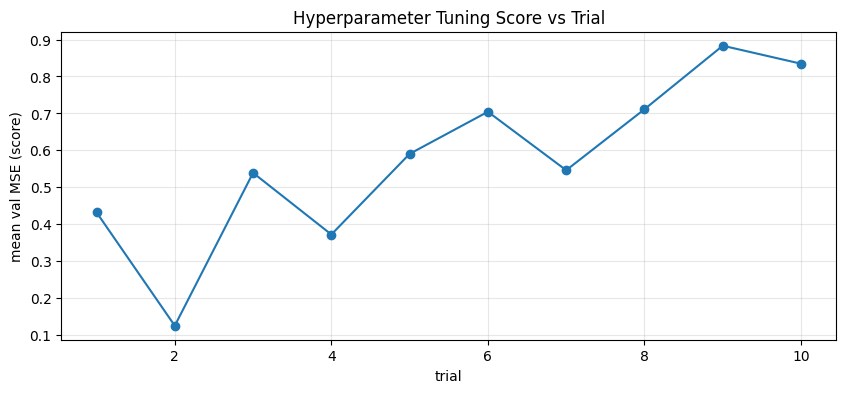

,trial,score,hidden_size,num_layers,dropout,lr,val_H,val_M,val_U,val_Z
0,2,0.124909,128,1,0.0,0.0010,0.162802,0.078853,0.047604,0.210378
1,4,0.372001,256,1,0.2,0.0003,0.477476,0.251255,0.208911,0.550362
2,1,0.432136,256,1,0.0,0.0001,0.558108,0.298970,0.238434,0.633032
3,3,0.539053,256,1,0.2,0.0001,0.688196,0.376110,0.314426,0.777482
4,7,0.546076,256,1,0.2,0.0001,0.698641,0.380392,0.318944,0.786327
5,5,0.590473,64,1,0.0,0.0010,0.749229,0.410369,0.351786,0.850509
6,6,0.704495,64,3,0.2,0.0010,0.889381,0.494125,0.433202,1.001274
7,8,0.711328,256,3,0.1,0.0010,0.850500,0.531287,0.496771,0.966754
8,10,0.834644,64,3,0.1,0.0003,1.035220,0.590169,0.540417,1.172769
9,9,0.883365,128,3,0.1,0.0010,1.082732,0.635457,0.590636,1.224635


{'hidden_size': 128, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001}

In [ ]:
# Hyperparameter tuning (verbose)
tune_out = tune_hyperparameters_verbose(
    model_name=MODEL_NAME,
    contract_splits=contract_splits,
    device=device,
    tune_trials=TUNE_TRIALS,
    tune_epochs=TUNE_EPOCHS,
    batch_size=BATCH_SIZE,
    horizon=HORIZON,
    max_train_batches_per_epoch=MAX_TRAIN_BATCHES_PER_EPOCH,
    max_val_batches=MAX_VAL_BATCHES,
    rng_seed=42,
)
best = tune_out['best']
trials_df = tune_out['trials_df']
plot_tuning_results(trials_df)
best_params = best['params']
assert best_params is not None
best_params

  0%|          | 0/138 [00:00<?, ?it/s]

epoch=001/8 train_mse=0.263010 val_H=0.358504 val_M=0.190513 val_U=0.137496 val_Z=0.415559


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=002/8 train_mse=0.093504 val_H=0.347542 val_M=0.185194 val_U=0.159725 val_Z=0.411974


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=003/8 train_mse=0.056421 val_H=0.194320 val_M=0.096249 val_U=0.066669 val_Z=0.245743


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=004/8 train_mse=0.055001 val_H=0.136759 val_M=0.063734 val_U=0.043386 val_Z=0.183564


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=005/8 train_mse=0.052213 val_H=0.103917 val_M=0.047323 val_U=0.038759 val_Z=0.156759


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=006/8 train_mse=0.049604 val_H=0.058342 val_M=0.023438 val_U=0.014668 val_Z=0.118084


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=007/8 train_mse=0.048605 val_H=0.069154 val_M=0.033561 val_U=0.031767 val_Z=0.138542


  0%|          | 0/138 [00:00<?, ?it/s]

epoch=008/8 train_mse=0.048850 val_H=0.087585 val_M=0.043889 val_U=0.030017 val_Z=0.149997


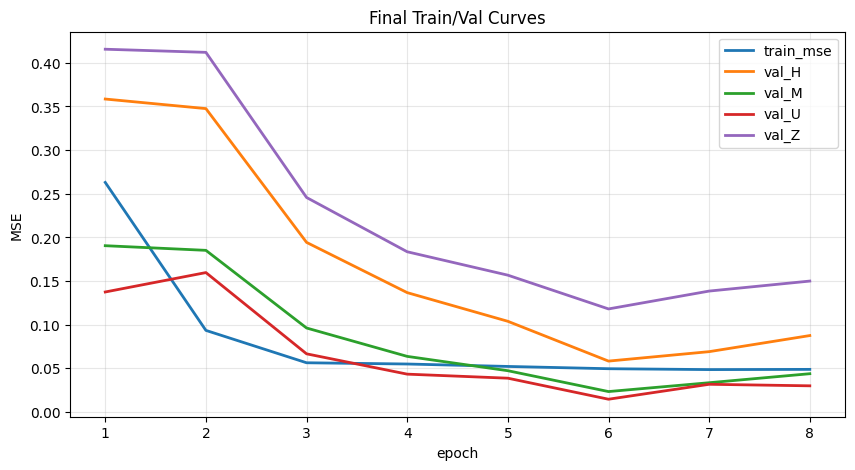

In [ ]:
# Final training with best hyperparameters
name = MODEL_NAME.strip().lower()
if name == 'direct_lstm':
    model = build_direct_lstm_forecaster(
        input_size=len(FEATURE_COLS),
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout'],
        horizon=HORIZON,
        output_size=len(FEATURE_COLS),
    ).to(device)
elif name == 'attn_lstm':
    model = build_attn_lstm_forecaster(
        input_size=len(FEATURE_COLS),
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout'],
        horizon=HORIZON,
        output_size=len(FEATURE_COLS),
    ).to(device)
elif name == 'cnn_lstm':
    model = build_cnn_lstm_forecaster(
        input_size=len(FEATURE_COLS),
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout'],
        horizon=HORIZON,
        output_size=len(FEATURE_COLS),
    ).to(device)
elif name == 'seq2seq_lstm':
    model = build_seq2seq_lstm_forecaster(
        input_size=len(FEATURE_COLS),
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout'],
    ).to(device)
else:
    model = build_model(name=MODEL_NAME, horizon=HORIZON, output_size=len(FEATURE_COLS)).to(device)

train_concat = ConcatDataset([contract_splits[c]['train'] for c in contract_splits])
train_loader = DataLoader(train_concat, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loaders = {
    f"val_{c}": DataLoader(contract_splits[c]['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    for c in contract_splits
}

final_history = train_verbose(
    model,
    train_loader=train_loader,
    val_loaders=val_loaders,
    epochs=FINAL_EPOCHS,
    lr=best_params['lr'],
    device=device,
    patience=EARLY_STOPPING_PATIENCE,
)
plot_training_curves(final_history, title=f"Final Curves ({MODEL_NAME}, target={TARGET_MODE})")

In [11]:
def last_input_close_unscaled(dataset: WeekToHourDataset, idx: int) -> float:
    start_day = dataset.week_starts[idx]
    seq = dataset._get_week_array(start_day)
    last_input = seq[dataset.input_len - 1]
    return float(last_input[CLOSE_IDX])

def compute_direction_confusion_matrix(
    *,
    model: nn.Module,
    test_sets: Dict[str, WeekToHourDataset],
    device: torch.device,
    max_samples_per_contract: int = 100,
) -> Tuple[np.ndarray, int]:
    y_true: List[int] = []
    y_pred: List[int] = []

    for c, ds in test_sets.items():
        n = min(len(ds), max_samples_per_contract)
        for i in range(n):
            pred, actual = predict_one_unscaled(model, ds, i, device)
            last_close = last_input_close_unscaled(ds, i)
            pred_close = pred[:, CLOSE_IDX]
            act_close = actual[:, CLOSE_IDX]

            pred_prev = np.concatenate([[last_close], pred_close[:-1]])
            act_prev = np.concatenate([[last_close], act_close[:-1]])

            pred_dir = (pred_close - pred_prev > 0).astype(np.int32)
            act_dir = (act_close - act_prev > 0).astype(np.int32)

            y_true.extend(act_dir.tolist())
            y_pred.extend(pred_dir.tolist())

    cm = confusion_matrix(np.array(y_true), np.array(y_pred), labels=[0, 1])
    return cm, len(y_true)

def per_sample_test_mse_curve(
    *,
    model: nn.Module,
    dataset: WeekToHourDataset,
    device: torch.device,
    max_samples: int = 200,
) -> np.ndarray:
    n = min(len(dataset), max_samples)
    mses = []
    for i in range(n):
        pred, actual = predict_one_unscaled(model, dataset, i, device)
        mses.append(float(np.mean((pred - actual) ** 2)))
    return np.array(mses, dtype=np.float32)

def plot_test_curves(test_sets: Dict[str, WeekToHourDataset], model: nn.Module, device: torch.device) -> None:
    plt.figure(figsize=(10, 4))
    for c, ds in test_sets.items():
        mses = per_sample_test_mse_curve(model=model, dataset=ds, device=device, max_samples=200)
        plt.plot(np.arange(len(mses)), mses, label=f"{c} per-sample MSE")
    plt.xlabel('sample index')
    plt.ylabel('MSE')
    plt.title('Test Per-Sample MSE Curves (subset)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

test_mse: {'test_H': 0.5732779651880264, 'test_M': 0.30245652571320536, 'test_U': 0.2680592965334654, 'test_Z': 0.607616800069809}


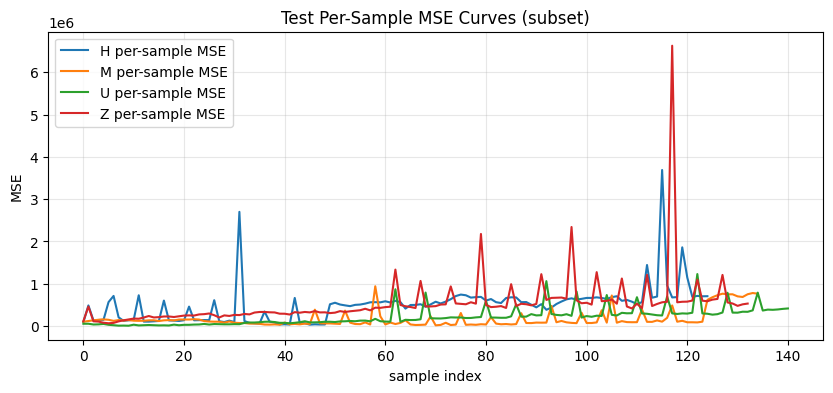

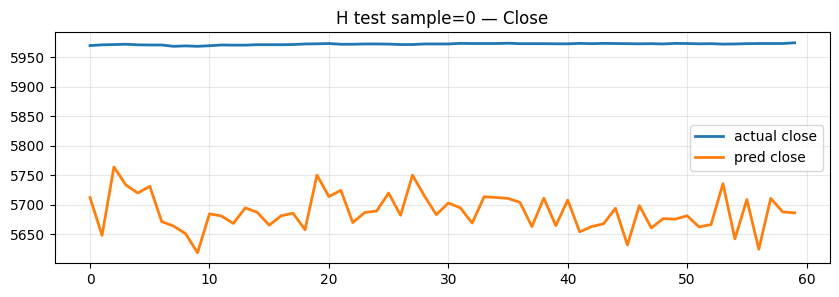

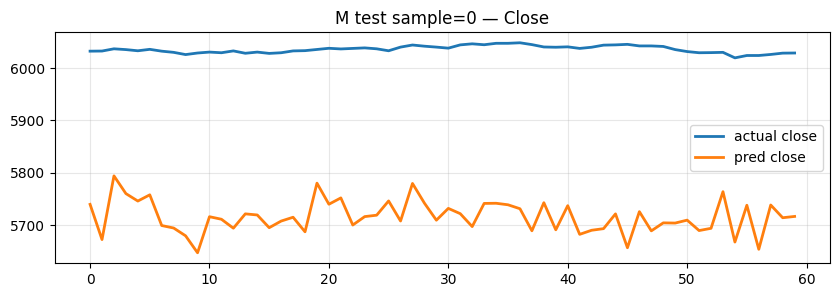

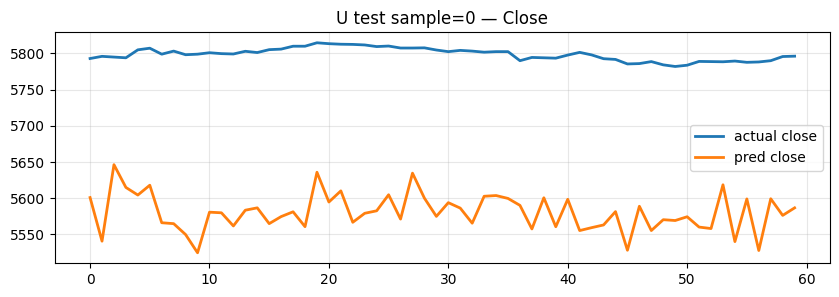

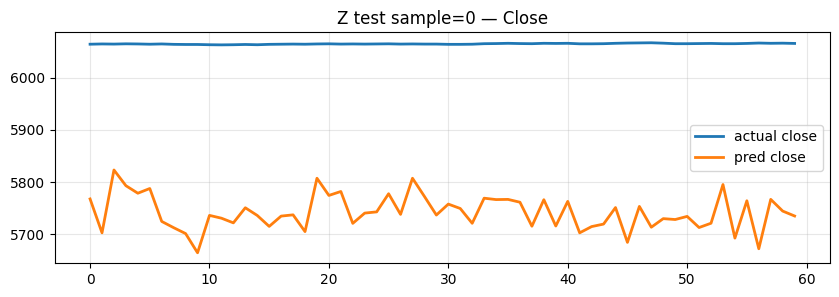

In [12]:
# Test evaluation + "test curves"
test_loaders = {
    f"test_{c}": DataLoader(contract_splits[c]['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    for c in contract_splits
}
test_report = {name: evaluate_model(model, loader, device) for name, loader in test_loaders.items()}
print('test_mse:', {k: float(v) for k, v in test_report.items()})

test_sets = {c: contract_splits[c]['test'] for c in contract_splits}
plot_test_curves(test_sets, model, device)

# Plot a few qualitative forecast-vs-actual examples (close only)
for c in ['H','M','U','Z']:
    ds = test_sets[c]
    if len(ds) == 0:
        continue
    idx = 0
    pred, actual = predict_one_unscaled(model, ds, idx, device)
    plt.figure(figsize=(10, 3))
    plt.plot(actual[:, CLOSE_IDX], label='actual close', linewidth=2)
    plt.plot(pred[:, CLOSE_IDX], label='pred close', linewidth=2)
    plt.title(f"{c} test sample={idx} — Close")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

test_direction_confusion_matrix (rows=true [down/flat, up], cols=pred [down/flat, up]):
[[7147 6134]
 [5795 4924]] n_labels= 24000


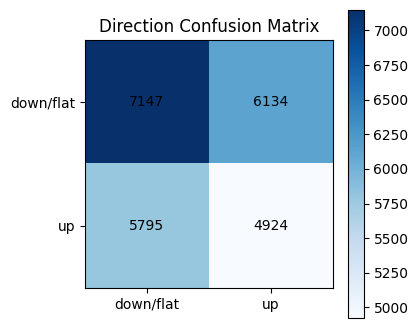

In [13]:
# Direction confusion matrix (test) + heatmap
cm, n = compute_direction_confusion_matrix(model=model, test_sets=test_sets, device=device, max_samples_per_contract=100)
print('test_direction_confusion_matrix (rows=true [down/flat, up], cols=pred [down/flat, up]):')
print(cm, 'n_labels=', n)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Direction Confusion Matrix')
plt.xticks([0,1], ['down/flat','up'])
plt.yticks([0,1], ['down/flat','up'])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center', color='black')
plt.colorbar()
plt.show()

saved: /content/artifacts/lstm_forecaster.pt
saved: /content/artifacts/scaler.json
plot_saved: /content/artifacts/plot_H_test_0.png


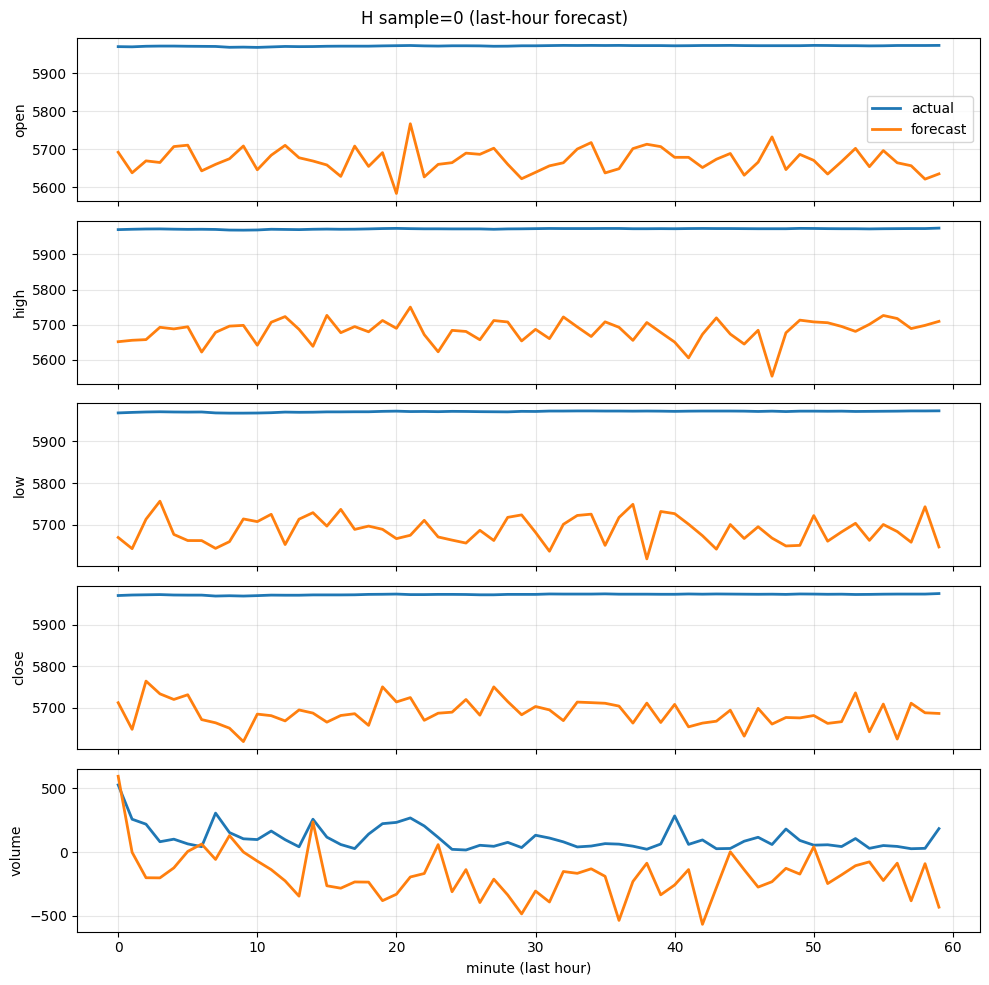

In [14]:
# Save artifacts (model checkpoint + scaler)
ckpt_path = ARTIFACTS_DIR / 'lstm_forecaster.pt'
meta_path = ARTIFACTS_DIR / 'scaler.json'

torch.save(
    {
        'model_state_dict': model.state_dict(),
        'feature_cols': FEATURE_COLS,
        'mean': mean,
        'std': std,
        'config': {
            'model_family': MODEL_FAMILY,
            'hidden_size': best_params['hidden_size'],
            'num_layers': best_params['num_layers'],
            'dropout': best_params['dropout'],
            'lr': best_params['lr'],
            'horizon': HORIZON,
            'days_per_sample': DAYS_PER_SAMPLE,
            'stride_days': STRIDE_DAYS,
        },
    },
    ckpt_path,
)
meta_path.write_text(json.dumps({'feature_cols': FEATURE_COLS, 'mean': mean.tolist(), 'std': std.tolist()}, indent=2))
print('saved:', ckpt_path)
print('saved:', meta_path)

# Optional: save a full multi-feature plot like the original script
plot_contract = 'H'
plot_split = 'test'
plot_idx = 0
ds = contract_splits[plot_contract][plot_split]
plot_path = ARTIFACTS_DIR / f"plot_{plot_contract}_{plot_split}_{plot_idx}.png"
plot_forecast_vs_actual(model=model, dataset=ds, idx=plot_idx, device=device, save_path=plot_path, show=True)